<a href="https://colab.research.google.com/github/sbbwoy/ESAA/blob/main/Kaggle_Optiver_Realized_Volatility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/leolu1998/lgbm-tabnet-nn-no-leaks-stratifiedgroupkfold/notebook 

## **Dataset**: stock market data relevant to the practical execution of trades in the financial markets
- order book snapshots and executed trades

- 150,000 target values




### **Files**

book_[train/test]
- 가장 자주 매매되는 주문에 대한 order book data
- level 1: more competitive in price terms, receive execution priority over the second level.

1. stock_id - ID code for the stock. 결측치 존재, Parquet 로딩 시 범주형으로 강제 변환하므로 int8로 변환할 것.
2. time_id - ID code for the time bucket. 순차적이진 않지만 모든 주식에서 일관성.
3. seconds_in_bucket - Number of seconds from the start of the bucket, 항상 0부터 시작
4. bid_price[1/2] - 높은 매도를 기록한 주식의 정규화된 가격
5. ask_price[1/2] - 높은 매수를 기록한 주식의 정규화된 가격
6. bid_size[1/2] - 높은 매도를 기록한 주식의 정규화된 수
7. ask_size[1/2] - 높은 매수를 기록한 주식의 정규화된 수

trade_[train/test].
- 실거래 데이터 

1. stock_id - Same as above.
2. time_id - Same as above.
3. seconds_in_bucket - Same as above. 반드시 0에서 시작X
5. price - 1초 동안 발생한 거래의 평균 가격(정규화). 평균은 각 거래에서 거래된 주식 수로 가중치 부여
6. size - 거래 주식의 총수
7. order_count - 발생한 고유 거래 주문 수



### train.csv 

1. stock_id - Same as above. 범주형X 정수로 로드.
2. time_id - Same as above.
3. target - 동일한 주식/시간ID의 데이터를 따라 10분에 걸쳐 계산된 실현 변동성. 피처 데이터와 타겟 데이터 사이 중복X. 



### test.csv 

1. stock_id - Same as above.
2. time_id - Same as above.
3. row_id - 제출 행의 고유 ID. 각 기존 시간/재고ID에는 하나의 행이 있음. 각 시간 창에는 모든 개별 주식이 포함되지 않음.

## Tabnet

In [ ]:
!pip install pytorch-tabnet==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.matlib

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

from scipy import stats
from scipy.stats import norm
from joblib import Parallel, delayed

import shutil
import glob

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

In [ ]:
#setting some global config

plt.style.use('ggplot')
orange_black = ['#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820']
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams["figure.facecolor"] = '#FFFACD'
plt.rcParams["axes.facecolor"] = '#FFFFE0'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = orange_black[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'


import warnings
warnings.filterwarnings("ignore")

In [ ]:
import psutil

def read_train_test():
    #Function to read our base train and test set
    train = pd.read_csv('/content/drive/MyDrive/22-여름 스터디/Optiver Realized Volatility Prediction/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/22-여름 스터디/Optiver Realized Volatility Prediction/test.csv')

    #Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    print(f'Our test set has {test.shape[0]} rows')
    print(f'Our training set has {train.isna().sum().sum()} missing values')
    print(f'Our test set has {test.isna().sum().sum()} missing values')
    
    return train, test

train, test = read_train_test()

Our training set has 428932 rows
Our test set has 3 rows
Our training set has 0 missing values
Our test set has 0 missing values


In [ ]:
train.head()

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62


In [ ]:
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [ ]:
#data directory
data_dir = "/content/drive/MyDrive/22-여름 스터디/Optiver Realized Volatility Prediction/"

def calc_wap1(df):
    #wap1 계산
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(series):
    return np.log(series).diff()

def realized_volatility(series):
    # Calculate the realized volatility
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    # Function to count unique elements of a series
    return len(np.unique(series))

In [ ]:
def book_preprocessor(file_path):
    # Function to preprocess book data (for each stock id)
    
    df = pd.read_parquet(file_path)
    
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
    }

    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Function to get group stats for different windows (seconds in bucket)
            
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
            
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
            
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature           #여기 뭐지.....?
        
        # Get the stats for different windows
        df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
        df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
        df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
        df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)

        def tendency(price, vol):    
            df_diff = np.diff(price)
            val = (df_diff/price[1:])*100
            power = np.sum(val*vol[1:])
            return(power)
    
        lis = []
        for n_time_id in df['time_id'].unique():
            df_id = df[df['time_id'] == n_time_id]        
            tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
            f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
            f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
            df_max =  np.sum(np.diff(df_id['price'].values) > 0)
            df_min =  np.sum(np.diff(df_id['price'].values) < 0)
            abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
            energy = np.mean(df_id['price'].values**2)
            iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
            abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
            energy_v = np.sum(df_id['size'].values**2)
            iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
            
            lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                    'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
        
        df_lr = pd.DataFrame(lis)
            
    
        df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')

        # Merge all
        df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
        df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
        df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')

        # Drop unnecesary time_ids
        df_feature.drop(['time_id__400', 'time_id__300', 'time_id__200'], axis = 1, inplace = True)
        
            
        # Create row_id so we can merge
        stock_id = file_path.split('=')[1]
        df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
        df_feature.drop(['time_id_'], axis = 1, inplace = True)
        
        return df_feature

In [ ]:
def trade_preprocessor(file_path):
    # Function to preprocess trade data (for each stock id)
    
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, realized_volatility, np.mean, np.std, np.max, np.min],
        'order_count':[np.mean,np.sum,np.max],
    }

    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Function to get group stats for different windows (seconds in bucket)
        
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)

    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')

    # Drop unnecesary time_ids
    df_feature.drop(['time_id__400', 'time_id__300', 'time_id__200','time_id'], axis = 1, inplace = True)
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)

    def order_sum(df, sec:str):
        new_col = 'size_tau' + sec
        bucket_col = 'trade_seconds_in_bucket_count_unique' + sec
        df[new_col] = np.sqrt(1/df[bucket_col])
            
        new_col2 = 'size_tau2' + sec
        order_col = 'trade_order_count_sum' + sec
        df[new_col2] = np.sqrt(1/df[order_col])
            
        if sec == '400_':
            df['size_tau2_d'] = df['size_tau2_400'] - df['size_tau2']
        

    
    for sec in ['','_200','_300','_400']:
        order_sum(df_feature, sec)
        
    df_feature['size_tau2_d'] = df_feature['size_tau2_400'] - df_feature['size_tau2']
    
    return df_feature

In [ ]:
def get_time_stock(df):
    # Function to get group stats for the stock_id and time_id
    
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    
    return df

In [ ]:
def create_agg_features(train, test):

    # Making agg features

    train_p = pd.read_csv('/content/drive/MyDrive/22-여름 스터디/Optiver Realized Volatility Prediction/train.csv')
    train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')
    corr = train_p.corr()
    ids = corr.index
    kmeans = KMeans(n_clusters=7, random_state=42).fit(corr.values)
    l = []
    for n in range(7):
        l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )

    mat = []
    matTest = []
    n = 0
    for ind in l:
        newDf = train.loc[train['stock_id'].isin(ind) ]
        newDf = newDf.groupby(['time_id']).agg(np.nanmean)
        newDf.loc[:,'stock_id'] = str(n)+'c1'
        mat.append ( newDf )
        newDf = test.loc[test['stock_id'].isin(ind) ]    
        newDf = newDf.groupby(['time_id']).agg(np.nanmean)
        newDf.loc[:,'stock_id'] = str(n)+'c1'
        matTest.append ( newDf )
        n+=1

    mat1 = pd.concat(mat).reset_index()
    mat1.drop(columns=['target'],inplace=True)
    mat2 = pd.concat(matTest).reset_index()
    
    mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
    
    mat1 = mat1.pivot(index='time_id', columns='stock_id')
    mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
    mat1.reset_index(inplace=True)
    
    mat2 = mat2.pivot(index='time_id', columns='stock_id')
    mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
    mat2.reset_index(inplace=True)
    
    prefix = ['log_return1_realized_volatility', 'total_volume_mean', 'trade_size_mean', 'trade_order_count_mean','price_spread_mean','bid_spread_mean','ask_spread_mean',
              'volume_imbalance_mean', 'bid_ask_spread_mean','size_tau2']
    selected_cols=mat1.filter(regex='|'.join(f'^{x}.(0|1|3|4|6)c1' for x in prefix)).columns.tolist()
    selected_cols.append('time_id')
    
    train_m = pd.merge(train,mat1[selected_cols],how='left',on='time_id')
    test_m = pd.merge(test,mat2[selected_cols],how='left',on='time_id')
    
    # filling missing values with train means

    features = [col for col in train_m.columns.tolist() if col not in ['time_id','target','row_id']]
    train_m[features] = train_m[features].fillna(train_m[features].mean())
    test_m[features] = test_m[features].fillna(train_m[features].mean())

    return train_m, test_m

In [ ]:
def preprocessor(list_stock_ids, is_train = True):
    # Funtion to make preprocessing function in parallel (for each stock id)
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    
    return df


# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()

# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()

# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

# Fill inf values
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)

# Aggregating some features
train, test = create_agg_features(train,test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


TypeError: ignored

In [ ]:
import os
for fold in range(5):
    !cp -r ../input/optiver-tabnet-models/fold{str(fold)}/* .
    !zip fold{str(fold)}.zip model_params.json network.pt
    
modelpath = [os.path.join("./",s) for s in os.listdir("./") if ("zip" in s)] 

cp: cannot stat '../input/optiver-tabnet-models/fold0/*': No such file or directory
	zip warning: name not matched: model_params.json
	zip warning: name not matched: network.pt

zip error: Nothing to do! (fold0.zip)
cp: cannot stat '../input/optiver-tabnet-models/fold1/*': No such file or directory
	zip warning: name not matched: model_params.json
	zip warning: name not matched: network.pt

zip error: Nothing to do! (fold1.zip)
cp: cannot stat '../input/optiver-tabnet-models/fold2/*': No such file or directory
	zip warning: name not matched: model_params.json
	zip warning: name not matched: network.pt

zip error: Nothing to do! (fold2.zip)
cp: cannot stat '../input/optiver-tabnet-models/fold3/*': No such file or directory
	zip warning: name not matched: model_params.json
	zip warning: name not matched: network.pt

zip error: Nothing to do! (fold3.zip)
cp: cannot stat '../input/optiver-tabnet-models/fold4/*': No such file or directory
	zip warning: name not matched: model_params.json
	z

In [ ]:
X = train.drop(['row_id', 'target', 'time_id'], axis = 1)
y = train['target']
X_test=test.copy()
X_test.drop(['time_id','row_id'], axis=1,inplace=True)

In [ ]:
def rmspe(y_true, y_pred):
    # Function to calculate the root mean squared percentage error
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [ ]:
class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))

In [ ]:
def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()

nunique = X.nunique()
types = X.dtypes

categorical_columns = []
categorical_dims =  {}

for col in X.columns:
    if  col == 'stock_id':
        l_enc = LabelEncoder()
        X[col] = l_enc.fit_transform(X[col].values)
        X_test[col] = l_enc.transform(X_test[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        scaler = StandardScaler()
        X[col] = scaler.fit_transform(X[col].values.reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

In [ ]:
cat_idxs = [ i for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(X.columns.tolist()) if f in categorical_columns]

tabnet_params = dict(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    n_d = 16,
    n_a = 16,
    n_steps = 2,
    gamma = 2,
    n_independent = 2,
    n_shared = 2,
    lambda_sparse = 0,
    optimizer_fn = Adam,
    optimizer_params = dict(lr = (2e-2)),
    mask_type = "entmax",
    scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False),
    scheduler_fn = CosineAnnealingWarmRestarts,
    seed = 42,
    verbose = 10
    
)

# kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)
# # Create out of folds array
# oof_predictions = np.zeros((X.shape[0], 1))
# test_predictions = np.zeros(X_test.shape[0])
# feature_importances = pd.DataFrame()
# feature_importances["feature"] = X.columns.tolist()
# stats = pd.DataFrame()
# explain_matrices = []
# masks_ =[]

clf =  TabNetRegressor(**tabnet_params)

# for fold, (trn_ind, val_ind) in enumerate(kfold.split(X)):
#     print(f'Training fold {fold + 1}')
#     X_train, X_val = X.iloc[trn_ind].values, X.iloc[val_ind].values
#     y_train, y_val = y.iloc[trn_ind].values.reshape(-1,1), y.iloc[val_ind].values.reshape(-1,1)


    
#     clf.fit(
#       X_train, y_train,
#       eval_set=[(X_val, y_val)],
#       max_epochs = 200,
#       patience = 50,
#       batch_size = 1024*20, 
#       virtual_batch_size = 128*20,
#       num_workers = 4,
#       drop_last = False,
#       eval_metric=[RMSPE],
#       loss_fn=RMSPELoss
#       )
    
#     saving_path_name = f"./fold{fold}"
#     saved_filepath = clf.save_model(saving_path_name)
    
#     explain_matrix, masks = clf.explain(X_val)
#     explain_matrices.append(explain_matrix)
#     masks_.append(masks[0])
#     masks_.append(masks[1])
      
#     oof_predictions[val_ind] = clf.predict(X_val)
#     test_predictions+=clf.predict(X_test.values).flatten()/5
#     feature_importances[f"importance_fold{fold}+1"] = clf.feature_importances_
    
#     stats[f'fold{fold+1}_train_rmspe']=clf.history['loss']
#     stats[f'fold{fold+1}_val_rmspe']=clf.history['val_0_rmspe']
preds=[]
for path in modelpath:
    
    clf.load_model(path)
    preds.append(clf.predict(X_test.values).squeeze(-1))
    
model1_predictions = np.mean(preds,axis=0)

Device used : cpu


# LGBM+NN

In [ ]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import lightgbm as lgb

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib
import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    """ https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation """
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in tqdm(sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])), total=len(groups_and_y_counts)):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def read_train_test():
    # Function to read our base train and test set
    
    train = pd.read_csv('/content/drive/MyDrive/22-여름 스터디/Optiver Realized Volatility Prediction/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/22-여름 스터디/Optiver Realized Volatility Prediction/test.csv')

    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    print(f'Our test set has {test.shape[0]} rows')
    print(f'Our training set has {train.isna().sum().sum()} missing values')
    print(f'Our test set has {test.isna().sum().sum()} missing values')
    
    return train, test

train, test = read_train_test()

Our training set has 428932 rows
Our test set has 3 rows
Our training set has 0 missing values
Our test set has 0 missing values


In [ ]:
# data directory
data_dir = '/content/drive/MyDrive/22-여름 스터디/Optiver Realized Volatility Prediction/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to aggregate 1st and 2nd WAP
def calc_wap12(df):
    var1 = df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']
    var2 = df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']
    den = df['bid_size1'] + df['ask_size1'] + df['bid_size2'] + df['ask_size2']
    return (var1+var2) / den

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap34(df):
    var1 = df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']
    var2 = df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']
    den = df['bid_size1'] + df['ask_size1'] + df['bid_size2'] + df['ask_size2']
    return (var1+var2) / den

def calc_swap12(df):
    return df['wap12'] - df['wap34']

def calc_tswap1(df):
    return -df['swap1'].diff()

def calc_tswap12(df):
    return -df['swap12'].diff()

def calc_wss12(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (ask - bid) / df['midprice']

In [ ]:
# Calculate order book depth
def calc_depth(df):
    depth = df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1'] + df['bid_price2'] * df[
               'bid_size2'] + df['ask_price2'] * df['ask_size2']
    return depth

# Calculate order book slope
def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)

# Calculate order book dispersion
def calc_dispersion(df):
    bspread = df['bid_price1'] - df['bid_price2']
    aspread = df['ask_price2'] - df['ask_price1']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']

#  order flow imbalance
def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d

# Turnover
def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

# Function to calculate the log of the return
def log_return(series):
    return np.log(series).diff()

def log_return_out(series):
    ret = np.log(series).diff()
    return remove_outliers(ret)

def remove_outliers(series):
    cu = 6
    ser_mean, ser_std = np.mean(series), np.std(series)
    series = series.where(series<=(ser_mean + cu*ser_std), ser_mean)
    series = series.where(series>=(ser_mean - cu*ser_std), ser_mean)
    return series

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))
    
def realized_volatility_downside(series):
    return np.sqrt(np.sum(series[series<0]**2))

def realized_volatility_upside(series):
    return np.sqrt(np.sum(series[series>0]**2))

# realized bipower variation 
def realized_bipowvar(series):
    cnt = series.count()
    if cnt<3:
        return np.nan
    else:
        cons = (np.pi/2)*(cnt/(cnt-2))
        return cons*np.nansum(np.abs(series)*np.abs(series.shift()))
    
# Calculate integrated quarticity
def realized_quarticity(series):
    return (series.count()/3)*np.sum(series**4)

# realized median variation 
def realized_medianvar(series):
    cnt = series.count()
    if cnt<3:
        return np.nan
    else:
        cons = (np.pi/(6-4*np.sqrt(3)+np.pi))*(cnt/(cnt-2))
        return cons*np.nansum(np.median([np.abs(series),np.abs(series.shift()),np.abs(series.shift(2))], axis=0)**2)
    
# Calculate the realized absolute variatian
def realized_absvar(series):
    return np.sqrt(np.pi/(2*series.count()))*np.sum(np.abs(series))

# Calculate weighted volatility
def realized_vol_weighted(series):
    return np.sqrt(np.sum(series**2)/series.count())

# Calculate the realized skew
def realized_skew(series):
    return np.sqrt(series.count())*np.sum(series**3)/(realized_volatility(series)**3)

# Calculate the realized kurtosis
def realized_kurtosis(series):
    return series.count()*np.sum(series**4)/(realized_volatility(series)**4)

In [ ]:
# Function to get group stats for different windows (seconds in bucket)
def get_stats_bins(df, feat_dict, bins, quantile=False):
    # Group by the window
    if bins==0:
        df_feature = df.groupby('time_id').agg(feat_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        df_feature = df_feature.rename(columns={'time_id_': 'time_id'})
    else:
        if quantile:
            df['sbins'] = pd.qcut(df.seconds_in_bucket, bins, labels=False)
            q = 'q'
        else:
            df['sbins'] = pd.cut(df.seconds_in_bucket, bins, labels=False)
            q = ''
        df_feature = None
        for i in range(bins):
            df_feat = df.loc[df.sbins==i].groupby('time_id').agg(feat_dict).reset_index()
            # Rename columns joining suffix
            df_feat.columns = ['_'.join(col) for col in df_feat.columns]
            # Add a suffix to differentiate bins
            df_feat = df_feat.rename(columns={col: col+'_'+q+str(bins)+'bins_'+str(i) for col in df_feat.columns})
            df_feat = df_feat.rename(columns={'time_id_'+'_'+q+str(bins)+'bins_'+str(i): 'time_id'})
            if isinstance(df_feature, pd.DataFrame):
                df_feature = pd.merge(df_feature, df_feat, how='left', on='time_id')
            else:
                df_feature = df_feat.copy()
        df = df.drop('sbins', axis=1)
    return df_feature

In [ ]:
# Function to get group stats for different windows (seconds in bucket)
def get_stats_window(df, feat_dict, window):
    # Group by the window
    if window==0:
        df_feature = df.groupby('time_id').agg(feat_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        df_feature = df_feature.rename(columns={'time_id_': 'time_id'})
    else:
        df_feature = None
        for w in range(window, 600, window):
            df_feat = df.loc[df.seconds_in_bucket>=w].groupby('time_id').agg(feat_dict).reset_index()
            # Rename columns joining suffix
            df_feat.columns = ['_'.join(col) for col in df_feat.columns]
            # Add a suffix to differentiate bins
            df_feat = df_feat.rename(columns={col: col+'_'+str(window)+'win_'+str(w) for col in df_feat.columns})
            df_feat = df_feat.rename(columns={'time_id_'+'_'+str(window)+'win_'+str(w): 'time_id'})
            if isinstance(df_feature, pd.DataFrame):
                df_feature = pd.merge(df_feature, df_feat, how='left', on='time_id')
            else:
                df_feature = df_feat.copy()
    return df_feature

In [ ]:
# Function to sample from the window and average
def get_stats_sampled(df, feat_dict, numsamp, fraction, boot):
    df_feature = None
    for i in range(numsamp):
        df_feat = df.groupby('time_id').sample(frac=fraction, random_state=i, replace=boot).reset_index(drop=True)
        df_feat = df_feat.groupby('time_id').agg(feat_dict).reset_index()
        df_feat.columns = ['_'.join(col) for col in df_feat.columns]
        if isinstance(df_feature, pd.DataFrame):
            df_feature += df_feat.values/numsamp   
        else:
            df_feature = df_feat.copy()/numsamp
    df_feature = df_feature.rename(columns={col: col+'_sample_'+str(fraction)+'_'+str(numsamp) for col in df_feature.columns})
    df_feature = df_feature.rename(columns={'time_id_'+'_sample_'+str(fraction)+'_'+str(numsamp): 'time_id'})
    return df_feature

In [ ]:
# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    
    #### Data Cleansing (if any needed)
    
    df = df.drop(df.loc[df.ask_price1 <= 0].index)
    df = df.drop(df.loc[df.bid_price1 <= 0].index)
    df = df.drop(df.loc[(df['ask_price1'] - df['bid_price1']) < 0].index)
    df = df.groupby(['time_id','seconds_in_bucket']).mean().reset_index()
    
    ####
    
    # Calculate prices
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    
    df['depth'] = calc_depth(df)
    df['slope'], _ = calc_slope(df)

    # Calculate log returns
    df['log_return1'] = df.groupby('time_id')['wap1'].apply(log_return)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    # Calculate spreads
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['dispersion'], _ = calc_dispersion(df)

    # Dict for aggregations
    create_feature_dict = {
        'depth': [np.sum],
        'slope': [np.sum],
        'log_return1': [realized_volatility, realized_absvar],
        'log_return2': [realized_volatility, realized_absvar],
        'price_spread': [np.sum, np.nanmedian],
    }

    create_feature_dict_bins = {
        'depth': [np.sum],
        'slope': [np.sum],
        'dispersion': [np.sum],
        'log_return1': [realized_volatility, realized_absvar],
        'log_return2': [realized_volatility, realized_absvar],
        'price_spread': [np.sum],
    }


    # Get the stats for different windows
    df_feature_0 = get_stats_bins(df, create_feature_dict, 0)
    df_feature_w4 = get_stats_window(df, create_feature_dict_bins, 150)

    # Merge all
    df_feature_0 = df_feature_0.merge(df_feature_w4, how = 'left', on = 'time_id')   

    df_feature_0 = df_feature_0.add_prefix('book_')
    stock_id = file_path.split('=')[1]
    df_feature_0['row_id'] = df_feature_0['book_time_id'].apply(lambda x:f'{stock_id}-{x}')
    df_feature_0.drop(['book_time_id'], axis = 1, inplace = True)
    return df_feature_0

In [ ]:
# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)

    #### Data Cleansing
    
    df = df.drop(df.loc[df.price <= 0].index)
    df = df.groupby(['time_id','seconds_in_bucket']).mean().reset_index()
    
    ####
    
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return': [realized_volatility, realized_absvar],
        'order_count':[np.sum, np.max],
    }
    
    create_feature_dict_bins = {
        'log_return': [realized_volatility, realized_absvar],
        'order_count': [np.sum],
    }
    
    # Get the stats for different windows
    df_feature_0 = get_stats_bins(df, create_feature_dict, 0)
    df_feature_w4 = get_stats_window(df, create_feature_dict_bins, 150)

    # Merge all
    df_feature_0 = df_feature_0.merge(df_feature_w4, how = 'left', on = 'time_id')   

    df_feature_0 = df_feature_0.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature_0['row_id'] = df_feature_0['trade_time_id'].apply(lambda x:f'{stock_id}-{x}')
    df_feature_0.drop(['trade_time_id'], axis = 1, inplace = True)
    return df_feature_0

In [48]:
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')      
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

In [49]:
# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')
gc.collect()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 46.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


4859

In [36]:
train['trade_size_tau'] = np.sqrt(1/train['trade_order_count_sum'])
    
for w in range(150, 600, 150):
    train['trade_size_tau_150win_'+str(w)] = np.sqrt(1/train['trade_order_count_sum_150win_'+str(w)])

In [37]:
test['trade_size_tau'] = np.sqrt(1/test['trade_order_count_sum'])
    
for w in range(150, 600, 150):
    test['trade_size_tau_150win_'+str(w)] = np.sqrt(1/test['trade_order_count_sum_150win_'+str(w)])

In [38]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

# Function to get group stats for the stock_id and time_id
def get_time_agg(df):
    gcols=['book_log_return1_realized_volatility']
    gcols+=['book_log_return1_realized_volatility_150win_150']
    gcols+=['book_log_return2_realized_volatility_150win_300']
    gcols+=['book_log_return1_realized_volatility_150win_450']+['trade_log_return_realized_volatility_150win_450']
    gcols+=['book_price_spread_sum_150win_150']
    gcols+=['trade_size_tau_150win_150']
    gcols+=['book_depth_sum_150win_150']
    gcols+=['book_dispersion_sum_150win_150']

    # Group by the stock id
    df_time_id = df.groupby('time_id')[gcols].agg(['mean', 'std', 'max', 'min']).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df_time_id = df_time_id.rename(columns={'time_id__time':'time_id'})
    return df_time_id, [col for col in df_time_id if col not in ['time_id']]

In [39]:
cols = ['row_id','time_id','stock_id','target']
cols+=['book_log_return1_realized_volatility']
cols+=['book_log_return1_realized_volatility_150win_150']+['book_log_return2_realized_volatility_150win_150']+[
            'trade_log_return_realized_volatility_150win_150']
cols+=['book_log_return1_realized_absvar_150win_150']+['book_log_return2_realized_absvar_150win_150']+[
            'trade_log_return_realized_absvar_150win_150']
cols+=['book_log_return2_realized_volatility_150win_300']
cols+=['book_log_return1_realized_volatility_150win_450']+['trade_log_return_realized_volatility_150win_450']
cols+=['book_price_spread_sum_150win_150']
cols+=['trade_size_tau_150win_150']
cols+=['book_depth_sum_150win_150']
cols+=['book_dispersion_sum_150win_150']

train = train[[col for col in train.columns if col in cols]]
test = test[[col for col in test.columns if col in cols]]

100%|██████████| 3830/3830 [01:33<00:00, 41.11it/s]


Training fold 1
(343146, 18)
(85786, 18)
Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 0.000470144	training's RMSPE: 0.217462	valid_1's rmse: 0.000484758	valid_1's RMSPE: 0.224871
[100]	training's rmse: 0.000455058	training's RMSPE: 0.210484	valid_1's rmse: 0.000478707	valid_1's RMSPE: 0.222065
[150]	training's rmse: 0.000446008	training's RMSPE: 0.206299	valid_1's rmse: 0.000476435	valid_1's RMSPE: 0.221011
[200]	training's rmse: 0.000439664	training's RMSPE: 0.203364	valid_1's rmse: 0.000474982	valid_1's RMSPE: 0.220336
[250]	training's rmse: 0.000433585	training's RMSPE: 0.200552	valid_1's rmse: 0.000473643	valid_1's RMSPE: 0.219716
[300]	training's rmse: 0.000428248	training's RMSPE: 0.198084	valid_1's rmse: 0.000473697	valid_1's RMSPE: 0.219741
Early stopping, best iteration is:
[254]	training's rmse: 0.000433156	training's RMSPE: 0.200354	valid_1's rmse: 0.000473488	valid_1's RMSPE: 0.219643
Training fold 2
(343146, 18)
(85786, 18)
Training u

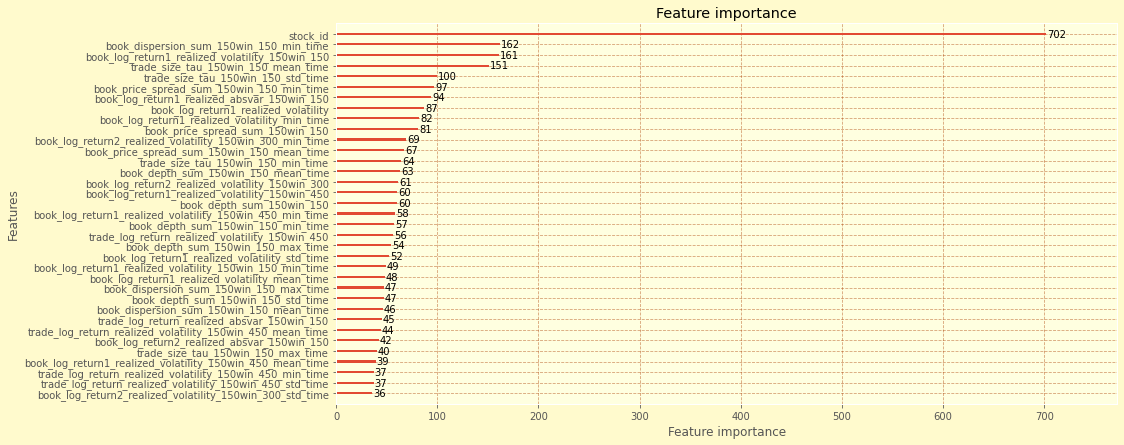

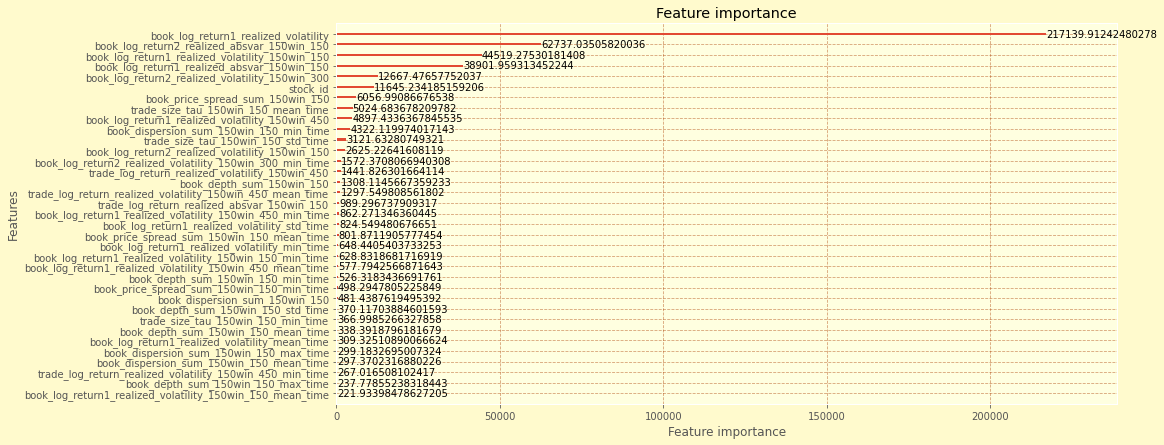

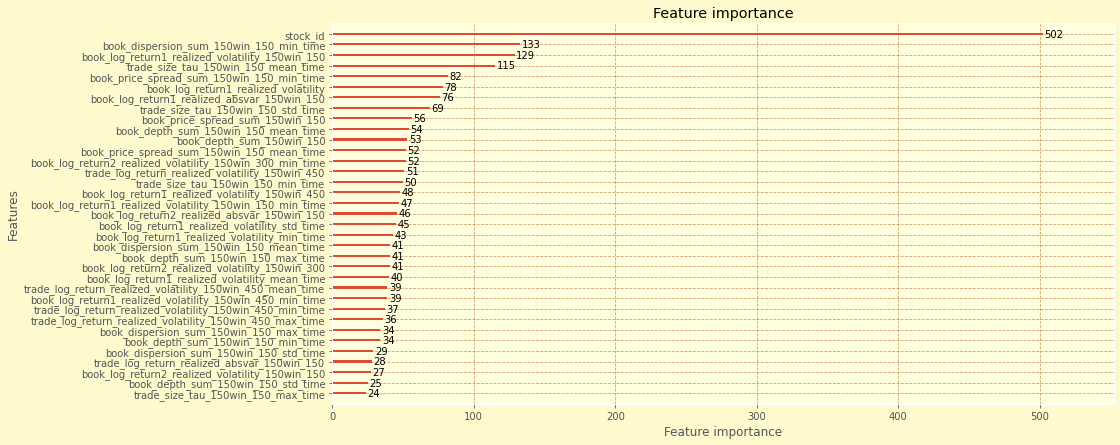

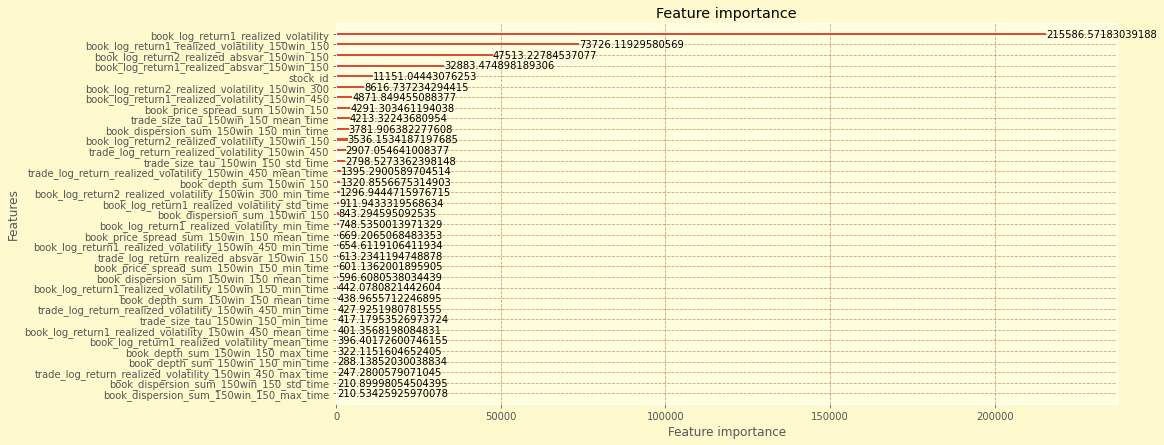

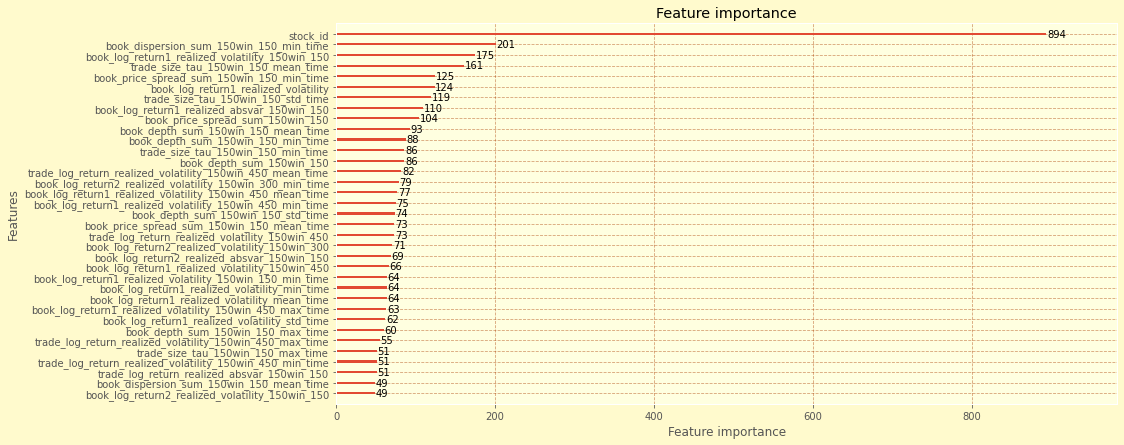

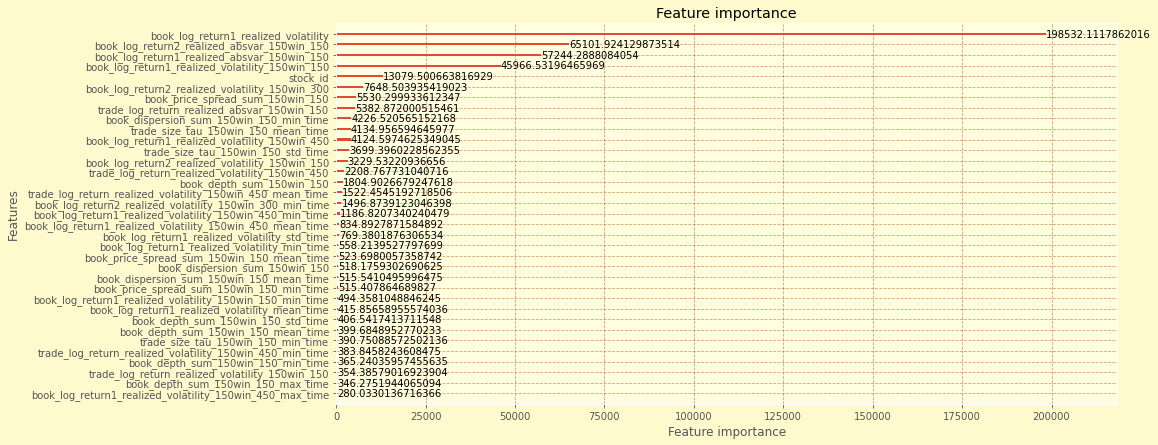

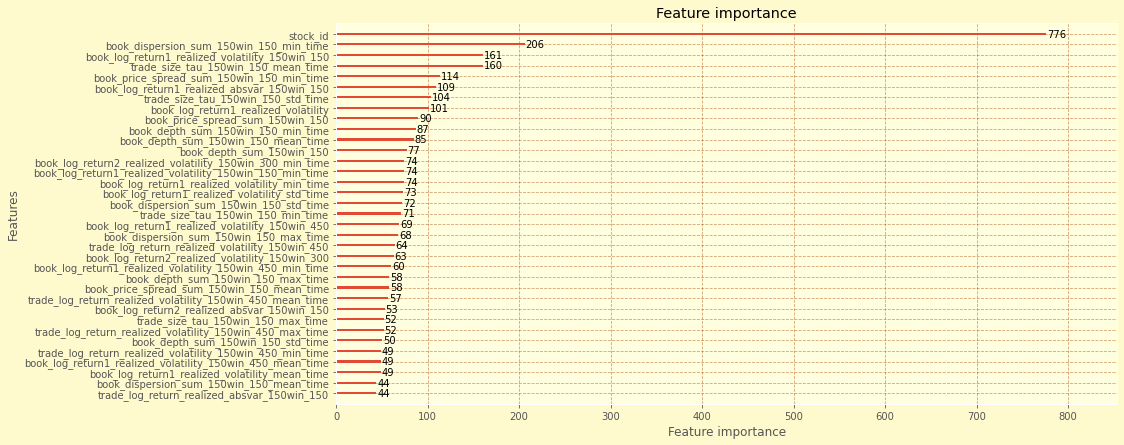

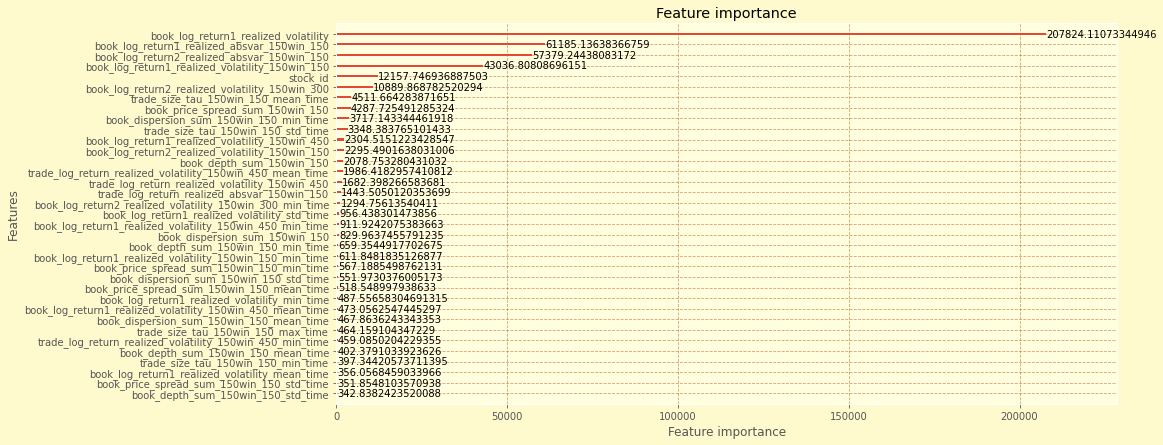

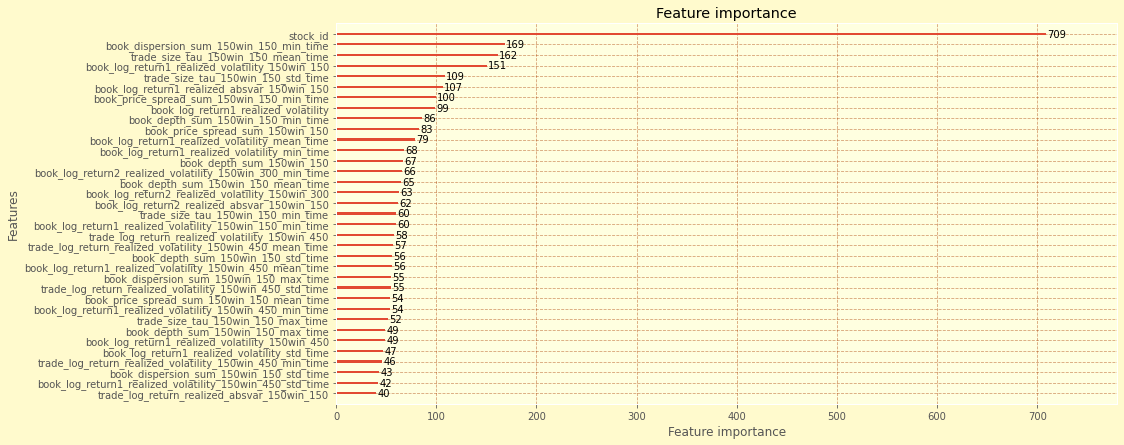

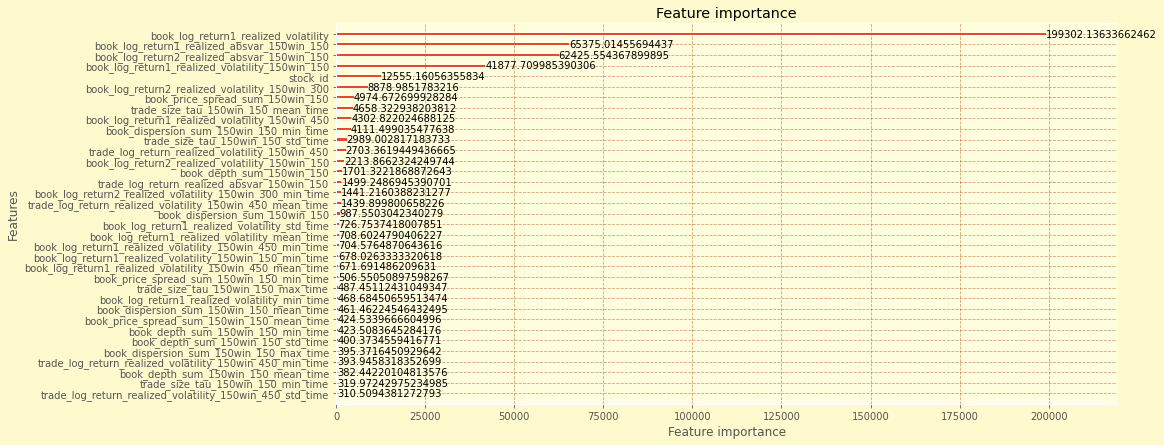

In [40]:
seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 4,
    'num_leaves': 15,
    'min_data_in_leaf': 250,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'feature_fraction': 0.8,
    'categorical_column': [0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}

def train_and_evaluate_lgb(train, test, params, try_seed=seed0):
    # Hyperparammeters (just basic)

    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    feats_nostock = [col for col in train.columns if col not in {"time_id", "target", "row_id", "stock_id"}] 
    # Create out of folds array
    y = train['target']
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kf = 5
    # Iterate through each fold
    skf = stratified_group_k_fold(X=train[feats_nostock], y=train['stock_id'].astype('category').cat.codes.values, 
                                  groups=np.array(train['time_id'].astype('category').cat.codes.values), k=kf, seed=try_seed)
    for fold, (trn_ind, val_ind) in enumerate(skf):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        print(x_train.shape)
        print(x_val.shape)
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        tt=test.copy()

        x_train_agg_time, agg_feats_time = get_time_agg(x_train)
        x_train = x_train.merge(x_train_agg_time, how='left', on='time_id')
        x_val_agg_time, _ = get_time_agg(x_val)
        x_val = x_val.merge(x_val_agg_time, how='left', on='time_id')
        test_agg_time, _ = get_time_agg(tt)
        tt = tt.merge(test_agg_time, how='left', on='time_id')
        del x_train_agg_time,  x_val_agg_time, test_agg_time
        gc.collect()
        
        traincols = features+agg_feats_time
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[traincols], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[traincols], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 50,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[traincols])
        # Predict the test set       
        test_predictions += model.predict(tt[traincols]) / kf
        plt.rcParams["figure.figsize"] = (14, 7) 
        lgb.plot_importance(model, max_num_features=35)
        plt.rcParams["figure.figsize"] = (14, 7) 
        lgb.plot_importance(model, max_num_features=35, importance_type='gain')
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')

    # Return test predictions
    return test_predictions

# Traing and evaluate
predictions_lgb_1 = train_and_evaluate_lgb(train, test, params0)

In [ ]:
seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'num_leaves': 31,
    'min_data_in_leaf': 100,
    'learning_rate': 0.05,
    'subsample': 0.95,
    'subsample_freq': 1,
    'feature_fraction': 0.9,
    'categorical_column': [0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}

def train_and_evaluate_lgb(train, test, params, try_seed=seed0):
    # Hyperparammeters (just basic)

    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    feats_nostock = [col for col in train.columns if col not in {"time_id", "target", "row_id", "stock_id"}] 
    # Create out of folds array
    y = train['target']
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kf = 10
    # Iterate through each fold
    skf = stratified_group_k_fold(X=train[feats_nostock], y=train['stock_id'].astype('category').cat.codes.values, 
                                  groups=np.array(train['time_id'].astype('category').cat.codes.values), k=kf, seed=try_seed)
    for fold, (trn_ind, val_ind) in enumerate(skf):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        print(x_train.shape)
        print(x_val.shape)
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        tt=test.copy()

        x_train_agg_time, agg_feats_time = get_time_agg(x_train)
        x_train = x_train.merge(x_train_agg_time, how='left', on='time_id')
        x_val_agg_time, _ = get_time_agg(x_val)
        x_val = x_val.merge(x_val_agg_time, how='left', on='time_id')
        test_agg_time, _ = get_time_agg(tt)
        tt = tt.merge(test_agg_time, how='left', on='time_id')
        del x_train_agg_time,  x_val_agg_time, test_agg_time
        gc.collect()
        
        traincols = features+agg_feats_time
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[traincols], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[traincols], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 50,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[traincols])
        # Predict the test set       
        test_predictions += model.predict(tt[traincols]) / kf
        plt.rcParams["figure.figsize"] = (14, 7) 
        lgb.plot_importance(model, max_num_features=35)
        plt.rcParams["figure.figsize"] = (14, 7) 
        lgb.plot_importance(model, max_num_features=35, importance_type='gain')
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')

    # Return test predictions
    return test_predictions

# Traing and evaluate
predictions_lgb_2 = train_and_evaluate_lgb(train, test, params0)

In [ ]:
from numpy.random import seed
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from tensorflow import keras
import numpy as np
from keras import backend as K
from keras.backend import sigmoid

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))

In [ ]:
def base_model(numfeats, cat_data=train['stock_id']):
    
    hidden_units = (64, 32, 32, 16, 16, 16, 16, 8, 8)
    stock_embedding_size = 24
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(numfeats,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='swish')(out)

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

In [ ]:
tf.random.set_seed(42)
seed(42)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=0,
                                      mode='min', restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, 
                                               verbose=0, mode='min')

scores_folds = {}
model_name = 'NN'

scores_folds[model_name] = []
counter = 1

predictions_nn_1 = np.zeros(test.shape[0])
y = train['target']
# Create a KFold object
kf = 5
# Iterate through each fold
features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
feats_nostock = [col for col in train.columns if col not in {"time_id", "target", "row_id", "stock_id"}] 
skf = stratified_group_k_fold(X=train[feats_nostock], y=train['stock_id'].astype('category').cat.codes.values, 
                              groups=np.array(train['time_id'].astype('category').cat.codes.values), k=kf, seed=2021)
for fold, (trn_ind, val_ind) in enumerate(skf):
    print(f'Training fold {fold + 1}')
    
    x_train = train.iloc[trn_ind].copy()
    x_val = train.iloc[val_ind].copy()
    print(x_train.shape)
    print(x_val.shape)
    y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
    tt = test.copy()

    x_train.loc[:, feats_nostock] = x_train.loc[:, feats_nostock].fillna(x_train.groupby('stock_id')[feats_nostock].transform('median')).values
    for i in x_val.stock_id.unique():
        x_val.loc[x_val.stock_id==i, feats_nostock] = x_val.loc[x_val.stock_id==i, feats_nostock].fillna(x_train.loc[x_train.stock_id==i, feats_nostock].median()).values
    for i in tt.stock_id.unique():
        tt.loc[tt.stock_id==i, feats_nostock] = tt.loc[tt.stock_id==i, feats_nostock].fillna(x_train.loc[x_train.stock_id==i, feats_nostock].median()).values
    
    x_train_agg_time, agg_feats_time = get_time_agg(x_train)
    x_train = x_train.merge(x_train_agg_time, how='left', on='time_id')
    x_val_agg_time, _ = get_time_agg(x_val)
    x_val = x_val.merge(x_val_agg_time, how='left', on='time_id')
    test_agg_time, _ = get_time_agg(tt)
    tt = tt.merge(test_agg_time, how='left', on='time_id')
    del x_train_agg_time,  x_val_agg_time, test_agg_time
    gc.collect()

    traincols = feats_nostock+agg_feats_time

    for i in tt.stock_id.unique():
        tt.loc[tt.stock_id==i, traincols] = tt.loc[tt.stock_id==i, traincols].fillna(x_train.loc[x_train.stock_id==i, traincols].median()).values

    num_trans = Pipeline([('qt', QuantileTransformer(n_quantiles=2000, output_distribution='normal')),
                         ('numscaler', MinMaxScaler())])
    agg_trans = Pipeline([('aggscaler', MinMaxScaler())])
    preprocessor = ColumnTransformer(transformers=[('num', num_trans, feats_nostock),
                                                    ('agg', agg_trans, agg_feats_time)])
    pipe = Pipeline([('pp', preprocessor)])
    pipe.fit(x_train[traincols])
    
    model = base_model(len(traincols))
    model.compile(
        keras.optimizers.Adam(learning_rate=0.001),
        loss=root_mean_squared_per_error
    )
    
    model.fit([x_train['stock_id'], pipe.transform(x_train[traincols])], 
              y_train,               
              batch_size=2048,
              epochs=1000,
              validation_data=([x_val['stock_id'], pipe.transform(x_val[traincols])], y_val),
              callbacks=[es, plateau],
              validation_batch_size=len(y_val),
              shuffle=True,
              verbose = 1)

    preds = model.predict([x_val['stock_id'], pipe.transform(x_val[traincols])]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_val, y_pred = preds), 5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    predictions_nn_1 += model.predict([tt['stock_id'], pipe.transform(tt[traincols])]).reshape(1,-1)[0].clip(0,1e10) / kf

    counter += 1
    
print('RMSPE {}: Folds: {}'.format(model_name, scores_folds[model_name]))

In [45]:
test['target'] = 0.988*predictions_nn_1*0.3+model1_predictions*0.3 + predictions_lgb_1*0.2 + predictions_lgb_2*0.2

display(test[['row_id', 'target']].head(3))
test[['row_id', 'target']].to_csv('submission.csv',index = False)

,row_id,target
0,0-4,NaN
1,0-32,NaN
2,0-34,NaN


,row_id,target
0,0-4,NaN
1,0-32,NaN
2,0-34,NaN
